# Handling and Visualizing Data

In [1]:
import os
import pandas as pd
import numpy as np 
import squarify 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import altair as alt
import colorcet as cc
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.palettes import Spectral11
from bokeh.models.sources import ColumnDataSource
import networkx as nx
from networkx.algorithms import bipartite

import preprocessing
import topic_modeling

In [2]:
folder_path = os.path.abspath('MovieSummaries')
df_movies, df_summaries = preprocessing.get_datasets(folderpath=folder_path)


In [3]:
df_genres = preprocessing.get_movie_genres_dataframe(df_movies=df_movies)
df_fictional_summaries, df_fictional = preprocessing.get_fictional_summaries_subset(df_genres=df_genres, df_movies=df_movies, df_summaries=df_summaries, return_df_fictional=True)

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre  release_year
0              975900         /m/01jfsb         Thriller        2001.0
1              975900          /m/06n90  Science Fiction        2001.0
2              975900          /m/03npn           Horror        2001.0
3              975900         /m/03k9fj        Adventure        2001.0
4              975900          /m/0fdjb     Supernatural        2001.0
The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [4]:
display(df_genres)

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre,release_year
0,975900,/m/01jfsb,Thriller,2001.0
1,975900,/m/06n90,Science Fiction,2001.0
2,975900,/m/03npn,Horror,2001.0
3,975900,/m/03k9fj,Adventure,2001.0
4,975900,/m/0fdjb,Supernatural,2001.0
...,...,...,...,...
243324,913762,/m/07s9rl0,Drama,1992.0
243325,12476867,/m/01jfsb,Thriller,2002.0
243326,12476867,/m/03npn,Horror,2002.0
243327,12476867,/m/01585b,Slasher,2002.0


## Movie Genres

In [5]:
df_genres_wo_Nan = df_genres.dropna(axis=0)

In [6]:
#Keeping only the n more represented genres
n=40
main_genres_name = df_genres_wo_Nan.groupby("movie_genre").count().sort_values("Wikipedia_movie_ID",ascending=False).reset_index()["movie_genre"].values[:n].tolist()
main_genres_number = df_genres_wo_Nan.groupby("movie_genre").count().sort_values("Wikipedia_movie_ID",ascending=False).reset_index()["Wikipedia_movie_ID"].values[:n].tolist()

df_main_genres = df_genres_wo_Nan.loc[df_genres_wo_Nan["movie_genre"].isin(main_genres_name)]
df_main_genres['release_year'] = df_main_genres['release_year'].astype(int)

#propotion of movies regarding the total number of movies released during the year

#Df with the number of movies released per year 
year_releases = df_genres_wo_Nan.drop_duplicates("Wikipedia_movie_ID").groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
sum_year_releases = year_releases["number of movies"].sum()

main_genres_year_releases = df_main_genres.drop_duplicates("Wikipedia_movie_ID").groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
main_genres_releases=main_genres_year_releases["number of movies"].sum()
main_genres_releases_ratio = main_genres_releases/sum_year_releases
display(main_genres_year_releases)

fictional_year_releases = df_fictional.groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
fictional_releases = fictional_year_releases["number of movies"].agg('sum')
fictional_ratio = fictional_releases/sum_year_releases



C:\Users\aubru\AppData\Local\Temp\ipykernel_80700\27416942.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_genres['release_year'] = df_main_genres['release_year'].astype(int)


,release_year,number of movies
0,1888,1
1,1889,1
2,1890,2
3,1891,3
4,1892,3
...,...,...
124,2012,1094
125,2013,155
126,2014,14
127,2015,4


In [7]:
#display(main_genres_proportion)
main_genres_proportion.reset_index(drop=True).rename(columns={"Wikipedia_movie_ID": "movie_count"})

NameError: name 'main_genres_proportion' is not defined

## FIRST PLOT Genres distribution

C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


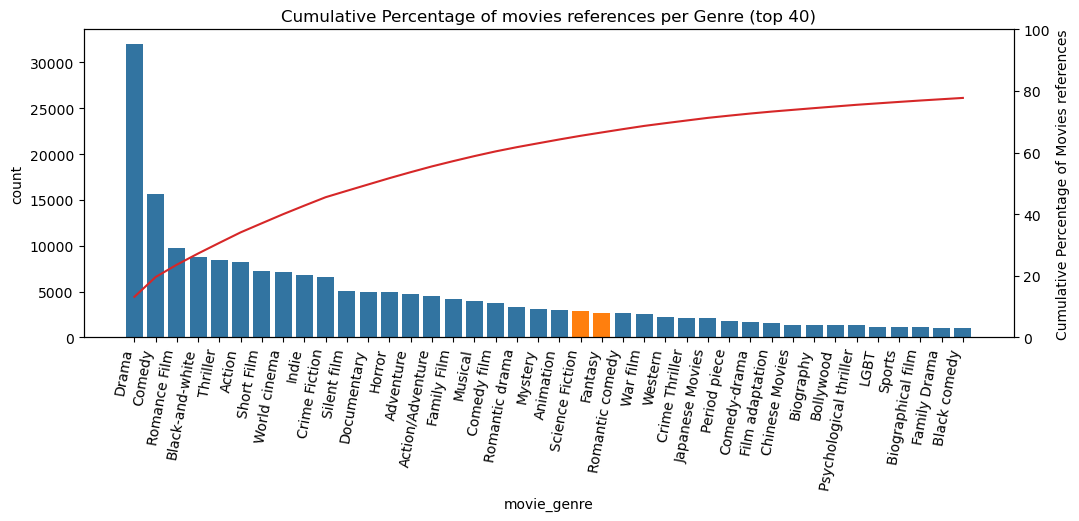

In [8]:

# Get the cumulative percentage of movie count by top-sorted genres
main_genres_proportion = df_main_genres.groupby("movie_genre").count().reset_index().sort_values('Wikipedia_movie_ID',ascending=False)["Wikipedia_movie_ID"].cumsum() / len(df_genres)
main_genres_proportion = main_genres_proportion.to_frame().reset_index().rename(columns={"Wikipedia_movie_ID": "movie_count"})

fig = plt.figure(figsize=(12, 4))


# make barplot and sort bars

ax1 = sns.countplot(x='movie_genre',data=df_main_genres, 
			order=df_main_genres.groupby("movie_genre").count().reset_index().sort_values('Wikipedia_movie_ID',ascending=False).movie_genre,color = 'tab:blue')
ax1.patches[21].set_facecolor('tab:orange')
ax1.patches[22].set_facecolor('tab:orange')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(main_genres_proportion["movie_count"]*100, label='Cumulative percentage of movies for the selected genres',color='tab:red')
ax2.set_ylim(0,100)
ax1.set_xticklabels(labels = df_main_genres.groupby("movie_genre").count().reset_index().sort_values('Wikipedia_movie_ID',ascending=False).movie_genre, rotation=80, ha='right')
plt.xlabel('Genres (Sorted by related movie Count)')
plt.ylabel('Cumulative Percentage of Movies references')
plt.title('Cumulative Percentage of movies references per Genre (top 40)')

plt.savefig("Genres_distribution")


## 2ND PLOT ADDING IMDB

In [9]:

imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')
# takes 30s

# remove movies without genre given
df_imdb_movie_genred = imdb_title_genre_df[~imdb_title_genre_df['genres'].isna()]
# Select rows where "Sci-Fi" or "Fantasy" appear in genres
df_imdb_fictional = df_imdb_movie_genred[df_imdb_movie_genred['genres'].str.contains('Sci-Fi|Fantasy', case=False, regex=True)]
# The full dataset from imdb
df_imdb_fictional.shape # row N = 312105


C:\Users\aubru\AppData\Local\Temp\ipykernel_80700\3930502513.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')


(314466, 9)

In [11]:
# Get all CMU movies which are fictional based IMDB dataset genres by merging on their name
df_fictional_cmu_imdb = pd.merge(df_movies,
                              df_imdb_fictional[[ 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']],
                              left_on='movie_name', right_on='primaryTitle', how='inner', suffixes = ['CMU', 'IMDB'])

df_genres_cmu_imdb = preprocessing.get_movie_genres_dataframe(df_movies=df_fictional_cmu_imdb)


   Wikipedia_movie_ID Freebase_genre_ID      movie_genre  release_year
0              975900         /m/01jfsb         Thriller        2001.0
1              975900          /m/06n90  Science Fiction        2001.0
2              975900          /m/03npn           Horror        2001.0
3              975900         /m/03k9fj        Adventure        2001.0
4              975900          /m/0fdjb     Supernatural        2001.0


In [12]:
df_genres_cmu_imdb_wo_Nan = df_genres_cmu_imdb.dropna(axis=0)

In [13]:
#Keeping only the n more represented genres
n=40
main_genres_name_cmu_imdb = df_genres_cmu_imdb_wo_Nan.groupby("movie_genre").count().sort_values("Wikipedia_movie_ID",ascending=False).reset_index()["movie_genre"].values[:n].tolist()
main_genres_number_cmu_imdb = df_genres_cmu_imdb_wo_Nan.groupby("movie_genre").count().sort_values("Wikipedia_movie_ID",ascending=False).reset_index()["Wikipedia_movie_ID"].values[:n].tolist()

df_main_genres_cmu_imdb = df_genres_cmu_imdb_wo_Nan.loc[df_genres_cmu_imdb_wo_Nan["movie_genre"].isin(main_genres_name_cmu_imdb)]
df_main_genres_cmu_imdb['release_year'] = df_main_genres_cmu_imdb['release_year'].astype(int)

#proportion of movies regarding the total number of movies released during the year

#Df with the number of movies released per year 
#year_releases_cmu_imdb = df_genres_cmu_imdb.drop_duplicates("Wikipedia_movie_ID").groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
#sum_year_releases_cmu_imdb = year_releases_cmu_imdb["number of movies"].sum()

#main_genres_year_releases = df_genres_cmu_imdb.drop_duplicates("Wikipedia_movie_ID").groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
#main_genres_releases=main_genres_year_releases["number of movies"].sum()
#main_genres_releases_ratio = main_genres_releases/sum_year_releases
#display(main_genres_year_releases)

#fictional_year_releases = df_fictional.groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
#fictional_releases = fictional_year_releases["number of movies"].agg('sum')
#fictional_ratio = fictional_releases/sum_year_releases

C:\Users\aubru\AppData\Local\Temp\ipykernel_80700\2163971.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_genres_cmu_imdb['release_year'] = df_main_genres_cmu_imdb['release_year'].astype(int)


C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Cumulative Percentage of movies references per Genre (top 40)')

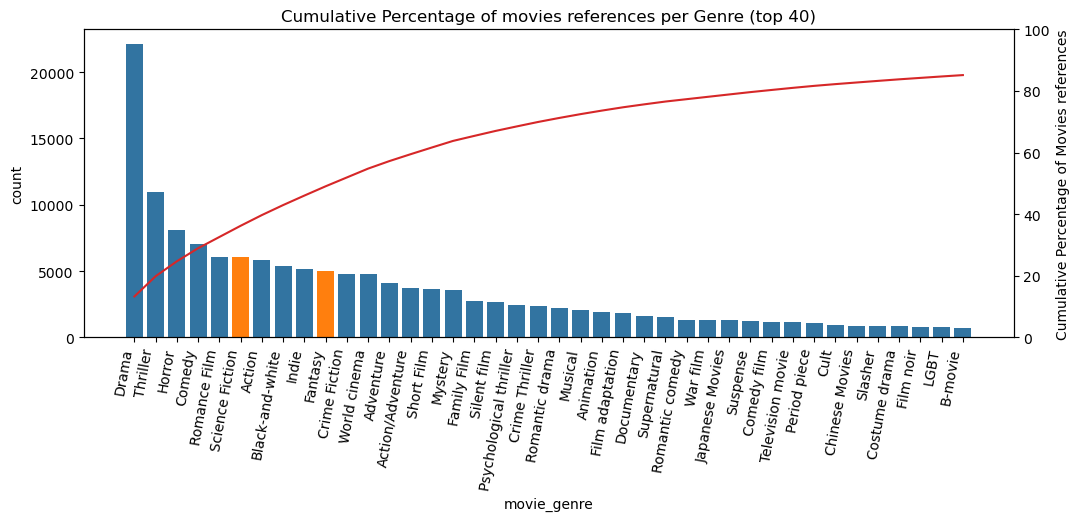

In [20]:
# Get the cumulative percentage of movie count by top-sorted genres
main_genres_proportion = df_main_genres_cmu_imdb.groupby("movie_genre").count().reset_index().sort_values('Wikipedia_movie_ID',ascending=False)["Wikipedia_movie_ID"].cumsum() / len(df_genres_cmu_imdb_wo_Nan)
main_genres_proportion = main_genres_proportion.to_frame().reset_index().rename(columns={"Wikipedia_movie_ID": "movie_count"})


fig = plt.figure(figsize=(12, 4))


# make barplot and sort bars

ax1 = sns.countplot(x='movie_genre',data=df_main_genres_cmu_imdb, 
			order=df_main_genres_cmu_imdb.groupby("movie_genre").count().reset_index().sort_values('Wikipedia_movie_ID',ascending=False).movie_genre,color = 'tab:blue')
ax1.patches[5].set_facecolor('tab:orange')
ax1.patches[9].set_facecolor('tab:orange')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(main_genres_proportion["movie_count"]*100, label='Cumulative percentage of movies for the selected genres',color='tab:red')
ax2.set_ylim(0,100)
ax1.set_xticklabels(labels = df_main_genres_cmu_imdb.groupby("movie_genre").count().reset_index().sort_values('Wikipedia_movie_ID',ascending=False).movie_genre, rotation=80, ha='right')
plt.xlabel('Genres (Sorted by related movie Count)')
plt.ylabel('Cumulative Percentage of Movies references')
plt.title('Cumulative Percentage of movies references per Genre (top 40)')


## 3RD PLOT Movies per country

In [22]:
display(df_fictional_cmu_imdb)



,Wikipedia_movie_ID,Freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,tconst,titleType,isAdult,primaryTitle,originalTitle,startYear,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,movie,0,Ghosts of Mars,Ghosts of Mars,2001,"Action,Horror,Sci-Fi"
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt2450324,tvEpisode,0,Ghosts of Mars,Ghosts of Mars,2012,"Action,Comedy,Fantasy"
2,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002.0,tt0075811,movie,0,The Sorcerer's Apprentice,Carodejuv ucen,1978,"Animation,Family,Fantasy"
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002.0,tt0120166,movie,0,The Sorcerer's Apprentice,The Sorcerer's Apprentice,2001,"Adventure,Family,Fantasy"
4,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002.0,tt0788639,tvEpisode,0,The Sorcerer's Apprentice,The Sorcerer's Apprentice,1971,"Family,Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51050,3868432,/m/0b44p5,Into the Mirror,2003-08-14,NaN,113.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}","{""/m/03npn"": ""Horror""}",2003.0,tt0372937,movie,0,Into the Mirror,Geoul sokeuro,2003,"Action,Fantasy,Horror"
51051,3868432,/m/0b44p5,Into the Mirror,2003-08-14,NaN,113.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}","{""/m/03npn"": ""Horror""}",2003.0,tt12512352,short,0,Into the Mirror,Into the Mirror,2020,"Comedy,Sci-Fi,Short"
51052,3868432,/m/0b44p5,Into the Mirror,2003-08-14,NaN,113.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}","{""/m/03npn"": ""Horror""}",2003.0,tt9882492,tvEpisode,0,Into the Mirror,Into the Mirror,2009,Sci-Fi
51053,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011.0,tt1816585,tvMovie,0,Mermaids: The Body Found,Mermaids: The Body Found,2011,Sci-Fi


## FOURTH PLOT

C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

Text(0.5, 1.0, 'Count of movie summaries classified as fictional per year')

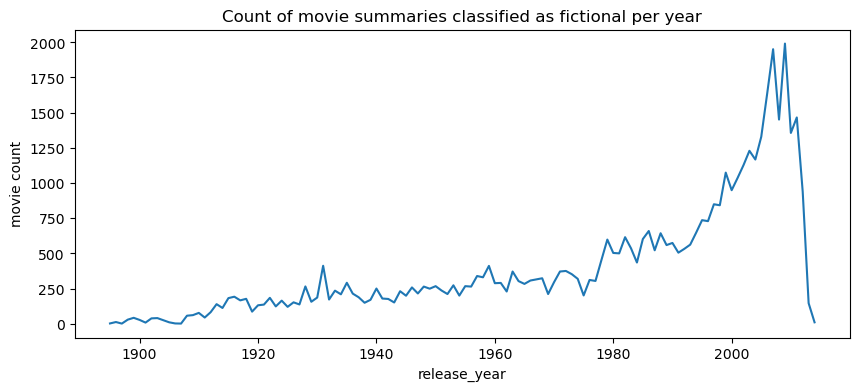

In [24]:
plt.figure(figsize=(10,4))
sns.lineplot(df_fictional_cmu_imdb.groupby('release_year')['Wikipedia_movie_ID'].agg("count"))
plt.ylabel('movie count')
plt.title('Count of movie summaries classified as fictional per year')

## Trash

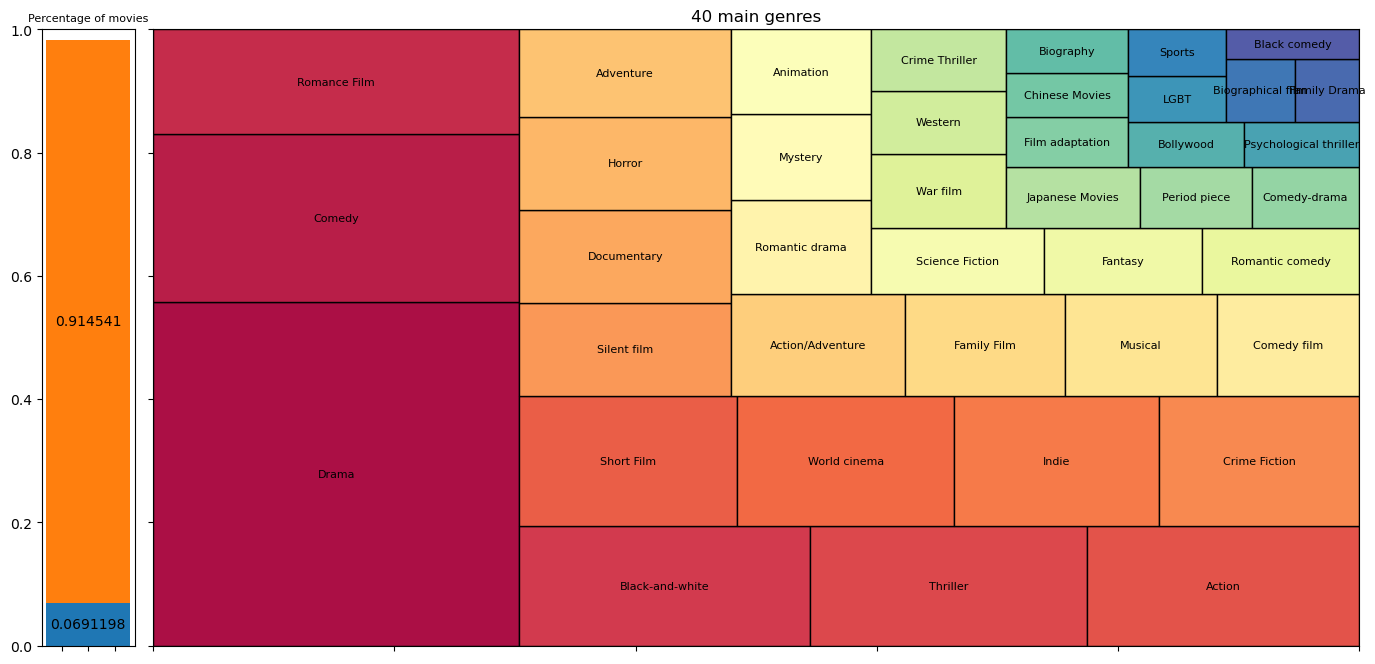

In [131]:


fig = plt.figure(figsize = (17,8))

gs = GridSpec(12, 12, figure=fig)

ax1 = fig.add_subplot(gs[:, 1:])
ax1 = squarify.plot(main_genres_number, label=main_genres_name, ec='black',color=sns.color_palette("Spectral", len(main_genres_number)),text_kwargs = {'fontsize': 8}) 
ax1.tick_params(labelbottom=False,labelleft=False)
ax1.set_title("%d main genres" % n)
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[:, 0])
ax2.tick_params(labelbottom=False, labelleft=True)
r1 = ax2.bar(0,fictional_ratio,
              label=("%d fictional movies \n %.2f %%" %(fictional_releases,fictional_ratio*100)))
ax2.bar_label(r1, label_type='center')
r2 = ax2.bar(0,main_genres_releases_ratio-fictional_ratio,bottom=fictional_ratio,label=("%d non fictional movies \n %.2f %%" %(main_genres_releases,main_genres_releases_ratio-fictional_ratio*100)))
ax2.bar_label(r2,label_type='center')
ax2.set_ylim([0, 1])

ax2.set_title("Percentage of movies",fontsize = 8)

plt.show()



In [133]:
imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')
# takes 30s

# remove movies without genre given
df_imdb_movie_genred = imdb_title_genre_df[~imdb_title_genre_df['genres'].isna()]
# Select rows where "Sci-Fi" or "Fantasy" appear in genres
df_imdb_fictional = df_imdb_movie_genred[df_imdb_movie_genred['genres'].str.contains('Sci-Fi|Fantasy', case=False, regex=True)]
# The full dataset from imdb
df_imdb_fictional.shape # row N = 312105



C:\Users\aubru\AppData\Local\Temp\ipykernel_72480\3177012562.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')


(314466, 9)

In [134]:
# Get all CMU movies which are fictional based IMDB dataset genres by merging on their name
df_fictional_cmu_imdb = pd.merge(df_movies,
                              df_imdb_fictional[[ 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']],
                              left_on='movie_name', right_on='primaryTitle', how='inner', suffixes = ['CMU', 'IMDB'])

In [112]:
fig = plt.figure(figsize = (17,8))

gs = GridSpec(8, 8, figure=fig)

ax1 = fig.add_subplot(gs[:, 1:])
ax1 = squarify.plot(main_genres_number, label=main_genres_name, ec='black',color=sns.color_palette("Spectral", len(main_genres_number)),text_kwargs = {'fontsize': 8}) 
ax1.tick_params(labelbottom=False,labelleft=False)
ax1.set_title("%d main genres" % n)
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[:, 0])
ax2.tick_params(labelbottom=False, labelleft=True)
ax2.stackplot([0,1],[main_genres_releases_ratio,main_genres_releases_ratio])
ax2.set_ylim([0, 1])
ax2.text(0.5, 0.5, "%d movies \n %.2f %%" % (main_genres_releases,main_genres_releases_ratio*100) , va="center", ha="center")
ax2.set_title("Percentage of movies",fontsize = 8)

plt.show()

,release_year,number of movies
0,1896.0,2
1,1898.0,1
2,1899.0,1
3,1900.0,2
4,1901.0,1
...,...,...
115,2012.0,81
116,2013.0,32
117,2014.0,4
118,2015.0,3


In [87]:
#Transform the relational table for the stack plot 

genres = df_main_genres['movie_genre'].unique().tolist()
years = df_main_genres['release_year'].sort_values().unique().tolist()

# Initialize dictionary to store the desired format
result_dict = {'years': years}

# Populate the dictionary with counts
for genre in genres:
    genre_counts = []
    for year in years:
        count = df_main_genres[(df_main_genres['movie_genre'] == genre) & (df_main_genres['release_year'] == year)].shape[0]
        genre_counts.append(count)
    result_dict[genre] = genre_counts

# Convert the result_dict to DataFrame
result_df = pd.DataFrame(result_dict)
#result_df = result_df.set_index("years",drop=True)
result_df["number_of_movies"] = df_main_genres.drop_duplicates("Wikipedia_movie_ID").groupby("release_year")['release_year'].count().values
result_df["total_number_of_movies"] = df_movies.groupby("release_year")['release_year'].count().values

# Print or use the result_df as needed
display(result_df)

,years,Thriller,Science Fiction,Horror,Adventure,Action,Mystery,Biographical film,Drama,Crime Fiction,...,Chinese Movies,Western,Sports,Family Drama,Biography,Documentary,Animation,LGBT,number_of_movies,total_number_of_movies
0,1888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,1889,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
3,1891,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
4,1892,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2012,172,42,100,58,187,38,29,427,60,...,4,5,9,0,3,75,50,6,1094,1194
125,2013,41,23,11,26,44,3,8,45,17,...,0,3,3,0,0,3,19,0,155,164
126,2014,1,1,0,5,1,0,1,4,0,...,0,0,0,0,0,0,1,0,14,17
127,2015,0,3,0,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,4,4


In [88]:
#Interractive Stacked plot 

p = figure(width=1200, height=800,x_range=(min(result_df["years"].tolist()),max(result_df["years"].tolist())), y_range=(-5000, 10000))

p.grid.minor_grid_line_color = '#eeeeee'
palette = cc.glasbey_dark[:len(genres)]
p.varea_stack(stackers=genres, x='years',legend_label=genres,source=result_df, fill_color=palette)

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(
    years=result_df["years"].tolist(),
    total_number_of_movies=-result_df["total_number_of_movies"].values,
    number_of_movies=-result_df["number_of_movies"].values,
    missing_movies=result_df["number_of_movies"].values - result_df["total_number_of_movies"].values,
    ratio =(result_df["number_of_movies"].values/result_df["total_number_of_movies"].values)*100))

# Plot the varea using the ColumnDataSource
varea = p.varea(x='years', y1='total_number_of_movies', y2='number_of_movies', color='black', legend_label='Missing movies with current genres selection', source=source)

# Add a HoverTool
hover = HoverTool(renderers=[varea],
                  tooltips=[("Years", "@years"),
                            ("Missing movies", "@missing_movies"),
                            ("Ratio (%)","@ratio")],)

p.add_tools(hover)

#p.line(result_df["years"].tolist(),-result_df["number_of_movies"].values,line_width=2,legend_label="Number of movies of the selected genres",color="red")
#p.line(result_df["years"].tolist(),-result_df["total_number_of_movies"].values,line_width=2,legend_label="Total_number of movies",color="black")
#p.varea(result_df["years"].tolist(),-result_df["total_number_of_movies"].values,-result_df["number_of_movies"].values, color='black',legend_label='Missing movies with current genres selection')
p.legend.location = "top_left"
p.legend.nrows = len(genres)//2+1
p.legend.ncols=2
p.legend.click_policy="mute"


show(p)

Index([1888.0, 1889.0, 1890.0, 1891.0, 1892.0, 1893.0, 1894.0, 1895.0, 1896.0,
       1897.0,
       ...
       2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0,
          nan],
      dtype='float64', name='years', length=130)

C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

<Axes: xlabel='release_year', ylabel='Count'>

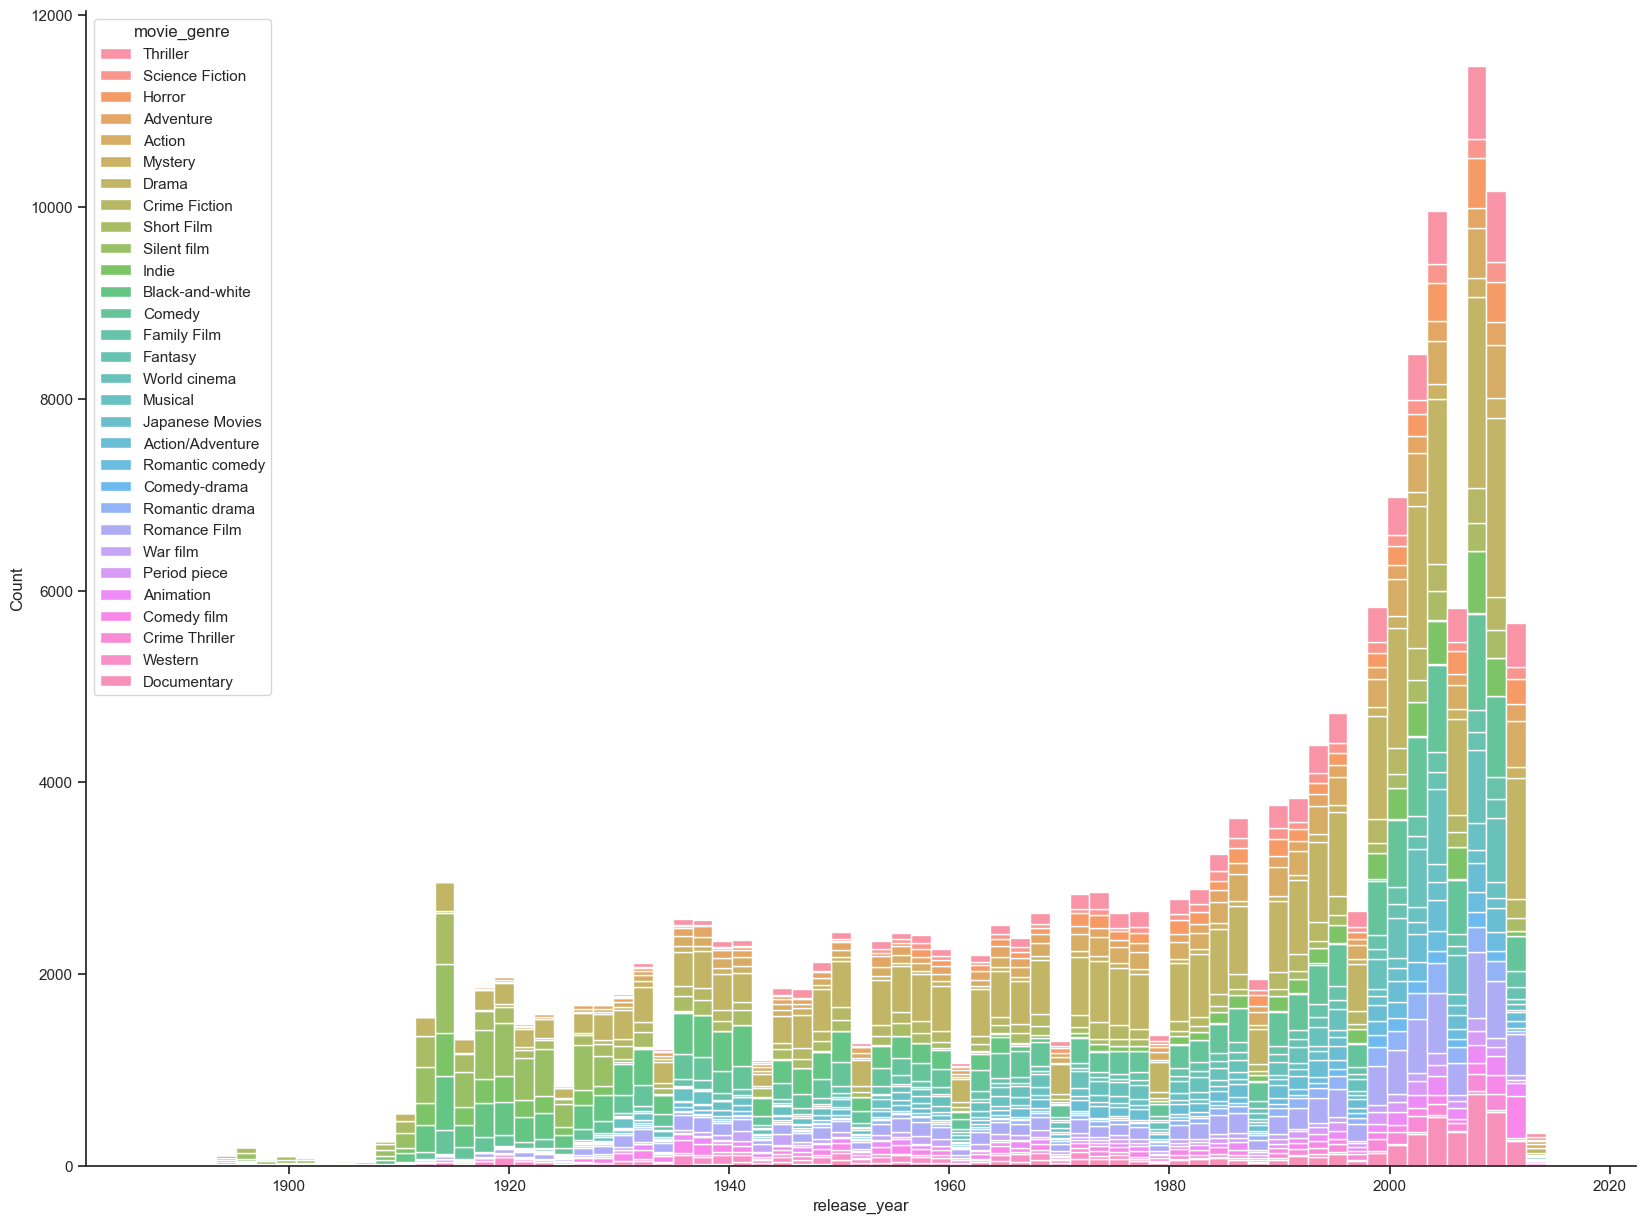

In [9]:


sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(20, 15))
sns.despine(f)

sns.histplot(
    df_main_genres,
    x="release_year", hue="movie_genre",
    multiple="stack",
    )


### Trying to build a bipartite graph to analyse the relations between genres. How close they are from each other

In [20]:
df_genres = df_genres[df_genres["movie_genre"]!='Romantic thriller']
Wikipedia_movie_ID = df_genres["Wikipedia_movie_ID"].unique().tolist()
Genres = df_genres["movie_genre"].unique().tolist()
Edges_WmovieID_Genres = df_genres[["Wikipedia_movie_ID","movie_genre"]].values.tolist()

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre
0,975900,/m/01jfsb,Thriller
1,975900,/m/06n90,Science Fiction
2,975900,/m/03npn,Horror
3,975900,/m/03k9fj,Adventure
5,975900,/m/02kdv5l,Action
...,...,...,...
243321,913762,/m/0hcr,Animation
243322,913762,/m/02hmvc,Short Film
243324,913762,/m/07s9rl0,Drama
243325,12476867,/m/01jfsb,Thriller


In [50]:
B = nx.Graph()
B.add_nodes_from(df_main_genres["Wikipedia_movie_ID"], bipartite=0)
B.add_nodes_from(df_main_genres["movie_genre"], bipartite=1)
B.add_edges_from([(row['Wikipedia_movie_ID'],row['movie_genre']) for idx, row in df_main_genres.iterrows()])



In [82]:
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes

G = bipartite.weighted_projected_graph(B, bottom_nodes)

#d = dict(G.degree)
dx,dy= bipartite.degrees(B,nodes=top_nodes)
d=dict(dx)
print(d)

{'War film': 2652, 'Romantic drama': 3372, 'Romance Film': 10234, 'Mystery': 3195, 'Crime Thriller': 2122, 'Indie': 6897, 'Silent film': 5250, 'Family Film': 4598, 'Black-and-white': 9094, 'Thriller': 8744, 'Adventure': 4963, 'Comedy': 16349, 'Fantasy': 2820, 'Documentary': 5630, 'Drama': 34007, 'Action': 8798, 'World cinema': 7155, 'Horror': 5280, 'Science Fiction': 3052, 'Animation': 3534, 'Crime Fiction': 6948, 'Western': 2225, 'Musical': 4160, 'Romantic comedy': 2680, 'Comedy film': 4362, 'Period piece': 1758, 'Comedy-drama': 1720, 'Action/Adventure': 4561, 'Short Film': 8141, 'Japanese Movies': 2322}


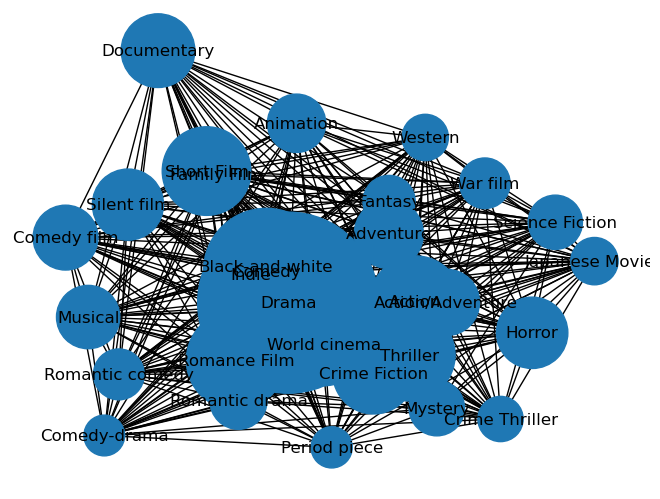

True

In [103]:
nx.draw(G,nodelist=d.keys(),with_labels=1,node_size=[v/2 for v in d.values()])

plt.show()
nx.is_connected(G)